## Deep Research Experiment with `LangGraph`

This notebook aims to test multi-round research with back-and-forth between an OpenAI LLM and Perplexity. Orchestrated with `LangGraph`.



In [101]:
import os

from dotenv import load_dotenv
load_dotenv()

from IPython.display import display, Markdown, Image
from langchain_core.messages import BaseMessage, SystemMessage, AIMessage
from langchain_openai import ChatOpenAI
from langgraph.graph import START, END, StateGraph
from langgraph.constants import Send
from langgraph.graph.state import CompiledStateGraph
from langgraph.graph.message import add_messages
import operator

from pydantic import BaseModel, Field
from typing import Annotated, Sequence, TypedDict, List, Dict

### Prompts

In [187]:
system_message_content = """You are a helpful assistant that can help with research."""
system_message = SystemMessage(content=system_message_content)

### research question writer

user_message_template = """
A user requires help with their research question. They have provided a topic they are interested in and the reason for their interest. Additionally, they have provided some background on themselves to help you understand their perspective.

<topic>
{topic}
</topic>

<reason>
{reason}
</reason>

<background>
{background}
</background>


Your task is to write research questions that can be submitted to Perplexity or Google Scholar for further research. Return a list of research questions.
"""

### answer writer prompt

answer_writer_template = """
You are assisting a user with their research. The topic is:

<topic>
{topic}
</topic>

The question you need to answer is:
<question>
{question}
</question>

Provide a detailed answer to the question.
"""

### research summarizer

research_summarizer_template = """
You are assisting a user with their research. The user has provided a research topic, for which questions have been already generated and answered. You will be provided with this list of questions and answers. Your task is to summarize the research in a professional way.

<topic>
{topic}
</topic>

<reason>
{reason}
</reason>

<background>
{background}
</background>

<questions and answers>
{questions_with_answers}
</questions and answers>

Provide the professional summary of the research.
"""

### further research validator

further_research_validator_template = """
You are assisting a user with their research. The user has provided a research topic, for which a research summary has been produced. Your task is to decide if, given the user's background and reason for interest, the summary is accurate and complete or any further deep dive is needed.

<topic>
{topic}
</topic>

<reason>
{reason}
</reason>

<background>
{background}
</background>

<research summary>
{research_summary}
</research summary>

Return with the decision if further questions are needed, a reason for the decision and if the decision is to go deeper, generate the next round of questions.
"""


### Structured Outputs

In [188]:
class ResearchQuestion(BaseModel):
    question: str = Field(description="A research question that can be submitted to Perplexity or Google Scholar for further research.")

class ResearchQuestions(BaseModel):
    questions: List[ResearchQuestion] = Field(description="A list of research questions that can be submitted to Perplexity or Google Scholar for further research.")

class FurtherResearchValidator(BaseModel):
    decision: bool = Field(description="A decision if further questions are needed (True) or not (False).")
    reason: str = Field(description="The reason for the decision.")
    questions: List[ResearchQuestion] = Field(description="A list of research questions that can be submitted to Perplexity or Google Scholar for further research.")


### LLMs

In [189]:
question_writer_model = "gpt-4o-2024-11-20"
further_research_validator_model = "gpt-4o-2024-11-20"
research_summarizer_model = "gpt-4o-2024-11-20"

question_writer_llm = ChatOpenAI(
    model=question_writer_model, 
    temperature=0.0
    )
question_writer_llm = question_writer_llm.with_structured_output(ResearchQuestions, method="json_schema", include_raw=True)

answer_writer_model = "llama-3.1-sonar-large-128k-online"
answer_writer_llm = ChatOpenAI(
    model=answer_writer_model, 
    temperature=0.0, 
    base_url="https://api.perplexity.ai", 
    api_key=os.getenv('PPLX_API_KEY')
    )

further_research_validator_llm = ChatOpenAI(
    model=further_research_validator_model, 
    temperature=0.0
    )
further_research_validator_llm = further_research_validator_llm.with_structured_output(FurtherResearchValidator, method="json_schema", include_raw=True)

research_summarizer_llm = ChatOpenAI(
    model=research_summarizer_model, 
    temperature=0.0
    )

### Build the graph

In [197]:
class AgentState(TypedDict):

    topic: str
    reason: str
    background: str

    messages: Annotated[Sequence[BaseMessage], add_messages]

    questions: List[str]
    question: str
    questions_with_answers: Annotated[List[Dict[str, str]], operator.add]

    further_research_rounds: int
    further_research_needed: bool

    research_summary: str

In [208]:
def write_questions(state: AgentState) -> AgentState:

    user_message = user_message_template.format(
        topic=state['topic'], 
        reason=state['reason'], 
        background=state['background']
        )
    
    response = question_writer_llm.invoke([system_message] + [user_message])

    response_parsed = response["parsed"]
    response_raw = response["raw"]
    response_raw.name = 'Question Writer'
    
    questions = [question.question for question in response_parsed.questions]
    
    return {
        'questions': questions,
        'messages': [system_message] + [user_message] + [response_raw]
        }

def answer_question(state: AgentState) -> AgentState:

    print(f'Answering question: {state["question"]}')

    user_message = answer_writer_template.format(
        topic=state['topic'], 
        question=state['question']
        )
    
    response = answer_writer_llm.invoke([system_message] + [user_message])
    response.name = 'Answer Writer'

    return {
        'messages': [response],
        'questions_with_answers': [{'question': state['question'], 'answer': response.content}]
        }

def send_questions_to_answer_writer(state: AgentState) -> AgentState:

    return [Send("answer_question", {"question": q, "topic": state['topic']}) for q in state['questions']]

def summarize_research(state: AgentState) -> AgentState:

    print('Summarizing research')

    user_message = research_summarizer_template.format(
        topic=state['topic'], 
        reason=state['reason'], 
        background=state['background'], 
        questions_with_answers=state['questions_with_answers']
        )
    
    response = research_summarizer_llm.invoke([system_message] + [user_message])
    response.name = 'Research Summarizer'

    return {
        'research_summary': response.content,
        'messages': [response]
        }


def validate_further_research(state: AgentState) -> AgentState:

    rounds_remaining = state['further_research_rounds']

    if rounds_remaining == 0:

        print('No further research rounds left.')

        return {
            'further_research_needed': False,
        }

    user_message = further_research_validator_template.format(
        topic=state['topic'], 
        reason=state['reason'], 
        background=state['background'], 
        research_summary=state['research_summary']
        )
    
    response = further_research_validator_llm.invoke([system_message] + [user_message])
    response_raw = response['raw']
    response_raw.name = 'Further Research Validator'

    if response['parsed'].decision:

        print(f'Further research needed. {rounds_remaining} rounds remaining max.')
        print(f'Reason: {response["parsed"].reason}')

        questions = [question.question for question in response['parsed'].questions]
        print(f'New questions: {questions}')
    
        return {
            'further_research_rounds': rounds_remaining - 1,
            'further_research_needed': True,
            'questions': questions, # overwrite questions with new questions
            'messages': [response_raw]
            }
    
    else:

        print('No further research needed.')
        print(f'Reason: {response["parsed"].reason}')
        return {
            'further_research_needed': False,
            'messages': [response_raw]
            }
    
def route_from_validation(state: AgentState):
    if state['further_research_needed']:
        return "go_deeper"
    else:
        return "end"
    
def get_new_questions(state: AgentState) -> AgentState:
    pass

In [209]:
workflow = StateGraph(AgentState)

workflow.add_node("write_questions", write_questions)
workflow.add_node("answer_question", answer_question)
workflow.add_node("summarize_research", summarize_research)
workflow.add_node("validate_further_research", validate_further_research)
workflow.add_node("get_new_questions", get_new_questions)

workflow.add_edge(START, "write_questions")
workflow.add_conditional_edges("write_questions", send_questions_to_answer_writer, ["answer_question"])
workflow.add_edge("answer_question", "summarize_research")
workflow.add_edge("summarize_research", "validate_further_research")

workflow.add_conditional_edges("validate_further_research", route_from_validation, {"end": END, "go_deeper": "get_new_questions"})
workflow.add_conditional_edges("get_new_questions", send_questions_to_answer_writer, ["answer_question"])


app = workflow.compile()

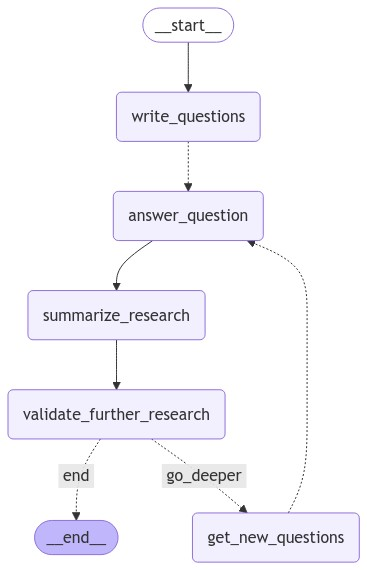

In [210]:
display(Image(app.get_graph().draw_mermaid_png()))

### Testing scenarios

In [211]:
scenarios = [
    {
        "topic": "The GOAT of the NFL",
        "reason": "I want to know who is the GOAT of the NFL. I have an ongoing debate with a friend between Tom Brady and Patrick Mahomes.",
        "background": "I am a football fan and I have been watching the NFL for 20 years.",
        "further_research_rounds": 3,
        "further_research_needed": True
    },
    {
        "topic": "How to cook the perfect steak",
        "reason": "I want to know how to cook the perfect steak. I just bought ribeyes and have not yet cooked ever before. I want medium rare.",
        "background": "I don't usually have time to cook but love steaks.",
        "further_research_rounds": 3,
        "further_research_needed": True
    },
    {
        "topic": "The best way to learn French",
        "reason": "I want to know the best way to learn French as I might need it for work.",
        "background": "I speak English and Russian, studied French a little bit in high school.",
        "further_research_rounds": 3,
        "further_research_needed": True
    }
]


In [212]:
scenarios_results = []

for scenario in scenarios:

    print(f'Running scenario: {scenario["topic"]}')

    test = app.invoke(scenario)
    scenarios_results.append(test)
    
    print('*' * 30)

Running scenario: The GOAT of the NFL
Answering question: Who is considered the greatest NFL player of all time (GOAT) and why?Answering question: What are the career achievements and statistics of Tom Brady and Patrick Mahomes?

Answering question: How do experts and analysts compare Tom Brady and Patrick Mahomes in terms of their impact on the NFL?
Answering question: What criteria are commonly used to determine the greatest NFL player of all time?
Answering question: What are the arguments for and against considering Tom Brady as the GOAT of the NFL?
Answering question: What are the arguments for and against considering Patrick Mahomes as the GOAT of the NFL?
Answering question: How do fans and analysts perceive the GOAT debate in the NFL?
Summarizing research
Further research needed. 3 rounds remaining max.
Reason: The research summary provides a comprehensive overview of the debate between Tom Brady and Patrick Mahomes as the GOAT of the NFL. However, given the user's background a

In [213]:
scenarios_results[0]

{'topic': 'The GOAT of the NFL',
 'reason': 'I want to know who is the GOAT of the NFL. I have an ongoing debate with a friend between Tom Brady and Patrick Mahomes.',
 'background': 'I am a football fan and I have been watching the NFL for 20 years.',
 'messages': [SystemMessage(content='You are a helpful assistant that can help with research.', id='132afb0d-6cea-4af9-9335-664d0dae20cc'),
  HumanMessage(content='\nA user requires help with their research question. They have provided a topic they are interested in and the reason for their interest. Additionally, they have provided some background on themselves to help you understand their perspective.\n\n<topic>\nThe GOAT of the NFL\n</topic>\n\n<reason>\nI want to know who is the GOAT of the NFL. I have an ongoing debate with a friend between Tom Brady and Patrick Mahomes.\n</reason>\n\n<background>\nI am a football fan and I have been watching the NFL for 20 years.\n</background>\n\n\nYour task is to write research questions that can

In [214]:
for scenario in scenarios_results:

    display(Markdown(scenario["research_summary"]))
    print('\n' * 2)

### Professional Summary: The GOAT of the NFL

The debate over the Greatest of All Time (GOAT) in the NFL is a complex and multifaceted discussion, with Tom Brady and Patrick Mahomes emerging as the two primary candidates. This research explores their respective achievements, career statistics, and the broader context of their impact on the game, while also considering the opinions of analysts, former players, and fans.

#### **Tom Brady: The Established GOAT**
Tom Brady is widely regarded as the GOAT due to his unparalleled career achievements, longevity, and consistent excellence. Over a 22-year career, Brady has amassed an NFL-record seven Super Bowl championships, five Super Bowl MVP awards, and three NFL MVP awards. He holds numerous all-time records, including most career passing yards (89,214), passing touchdowns (649), and wins (251). His ability to perform under pressure, particularly in the playoffs, is unmatched, with 35 postseason wins, 13,400 playoff passing yards, and 88 playoff touchdowns. Brady's leadership, adaptability, and work ethic have been instrumental in his success, both with the New England Patriots under Bill Belichick and later with the Tampa Bay Buccaneers.

Brady's longevity and ability to sustain elite performance over two decades set him apart. Analysts and players often cite his consistency, clutch performances, and leadership as defining traits of his greatness. Surveys among NFL players overwhelmingly favor Brady as the GOAT, with many pointing to his seven Super Bowl rings as the ultimate measure of success.

#### **Patrick Mahomes: The Rising Contender**
Patrick Mahomes, despite being early in his career, has already built a compelling case as a future GOAT. At just 28 years old, Mahomes has won three Super Bowl championships, three Super Bowl MVP awards, and two NFL MVP awards. His dynamic playmaking ability, mobility, and efficiency are reflected in his advanced metrics, including a higher career passer rating (103.5) and yards per attempt (7.9) compared to Brady. Mahomes has also demonstrated exceptional playoff performance, with a 14-3 postseason record and a strong track record in comeback situations.

Mahomes' early career success is unprecedented, and his potential to sustain this level of performance over the next decade positions him as a strong contender to surpass Brady. However, analysts and players agree that Mahomes must maintain his dominance and achieve greater longevity to match Brady's legacy.

#### **Key Comparisons**
- **Team Success**: Brady's seven Super Bowl wins and ten appearances are unmatched, while Mahomes' three championships in his first six seasons highlight his rapid ascent.
- **Individual Accolades**: Brady's extensive list of awards and records reflects his sustained excellence, while Mahomes' early career accolades, including multiple MVPs and Super Bowl MVPs, demonstrate his dominance in the modern era.
- **Advanced Metrics**: Mahomes leads in rate statistics such as completion percentage (66.5%) and passer rating, while Brady's counting stats, such as total passing yards and touchdowns, reflect his longevity.
- **Playoff Performance**: Both quarterbacks excel in the postseason, with Brady's consistency over 48 playoff games and Mahomes' ability to perform under pressure in critical moments.

#### **Supporting Teams and Coaching**
Both quarterbacks have benefited from strong organizational support. Brady's partnership with Bill Belichick and the New England Patriots' system was instrumental in his success, while Mahomes has thrived under Andy Reid's innovative coaching and the Kansas City Chiefs' talented roster. The influence of coaching, team culture, and supporting players has been pivotal in shaping their legacies.

#### **Broader Context and Era**
The era in which a player competes significantly impacts their evaluation. Brady's career spanned multiple decades, adapting to changes in the game, while Mahomes plays in a more pass-oriented league with advanced offensive schemes. Adjusting for these contextual differences is essential when comparing their greatness.

#### **Opinions of Analysts and Players**
NFL analysts and former players largely agree that Brady is the current GOAT due to his longevity, championships, and consistency. However, many acknowledge Mahomes' potential to surpass Brady if he continues his current trajectory. Projections suggest that Mahomes could break several of Brady's records if he maintains his performance over the next 15 years.

#### **Conclusion**
Tom Brady's extensive career achievements, unmatched Super Bowl success, and sustained excellence over two decades solidify his position as the GOAT of the NFL. However, Patrick Mahomes' early dominance, efficiency, and potential for future success make him a strong contender to eventually claim the title. The GOAT debate ultimately hinges on whether one values longevity and sustained success (Brady) or peak performance and potential (Mahomes). While Brady remains the benchmark, Mahomes is rapidly closing the gap, and his continued success could redefine the conversation in the years to come.

### Professional Summary: How to Cook the Perfect Steak

Cooking the perfect steak, particularly a ribeye to medium rare, requires a combination of proper preparation, precise techniques, and attention to detail. This guide provides a comprehensive overview of the essential steps, tools, and tips for beginners to achieve a flavorful, tender, and perfectly cooked steak.

#### Preparation and Seasoning
- **Preparation**: Allow the steak to come to room temperature for 30-60 minutes before cooking to ensure even cooking. Pat the steak dry with paper towels to remove excess moisture, which helps achieve a good sear.
- **Seasoning**: Generously season the steak with salt and freshly ground black pepper. For added flavor, consider using a blend of garlic powder, onion powder, smoked paprika, or fresh herbs like rosemary and thyme. Salt should be applied 30-45 minutes before cooking to create a brine that enhances flavor and moisture retention.

#### Cooking Techniques
- **Pan-Searing**: Use a heavy-bottomed pan, such as cast iron, and preheat it over medium-high heat until very hot. Add a high smoke point oil (e.g., canola or avocado oil) and sear the steak for 3-4 minutes per side to develop a golden-brown crust. For additional flavor, baste the steak with butter, garlic, and herbs during the final minute of cooking.
- **Grilling**: Preheat the grill to medium-high heat (375°F) and cook the steak for 5-6 minutes per side for medium rare. Grilling imparts a smoky flavor and is ideal for outdoor cooking.
- **Oven Method**: Sear the steak in a hot pan for 2 minutes per side, then transfer it to a preheated oven at 400°F for 11-14 minutes to finish cooking.

#### Doneness and Temperature
- The ideal internal temperature for medium rare is 130°F-135°F (54°C-57°C). Use an instant-read meat thermometer to ensure accuracy. Remove the steak from heat at 128°F-130°F, as it will continue to cook slightly during resting.

#### Resting and Slicing
- After cooking, let the steak rest for 5-10 minutes, tented with foil, to allow the juices to redistribute. Slice the steak against the grain to maximize tenderness.

#### Tools and Equipment
- Essential tools include a cast iron skillet, meat thermometer, tongs, and a sharp steak knife. A cooling rack and carving board are also helpful for resting and slicing the steak.

#### Common Mistakes and How to Avoid Them
- **Cooking Cold Steak**: Always bring the steak to room temperature before cooking to avoid uneven doneness.
- **Skipping Preheating**: Ensure the pan or grill is thoroughly preheated to achieve a proper sear.
- **Overcooking**: Use a thermometer to monitor the internal temperature and avoid overcooking.
- **Not Resting the Steak**: Resting is crucial to retain juices and enhance tenderness.
- **Flipping Too Often**: Flip the steak only once or twice to allow a crust to form.

#### Safety Precautions
- Practice proper hygiene by washing hands and utensils after handling raw meat to prevent cross-contamination. Use separate cutting boards for raw meat and other ingredients. When using a hot skillet, handle it with care using oven mitts, and avoid overcrowding the pan to ensure even cooking.

#### Enhancing Flavor
- For added flavor, consider marinades such as soy sauce and Worcestershire sauce blends or balsamic vinegar-based marinades. Alternatively, serve the steak with sauces like chimichurri or bearnaise.

#### Salvaging Overcooked Steak
If the steak is overcooked, rehydrate it by simmering in broth or sauce, or repurpose it into dishes like tacos, casseroles, or sandwiches.

By mastering these techniques and avoiding common pitfalls, even a beginner can cook a restaurant-quality steak with a flavorful crust and juicy interior.

### Research Summary: The Best Way to Learn French

#### Objective
The research explores the most effective methods, techniques, and resources for learning French, particularly for English and Russian speakers, with a focus on professional purposes. The findings aim to provide a comprehensive guide for individuals seeking to learn or relearn French efficiently, leveraging prior language knowledge and modern tools.

---

#### Key Findings

1. **Effective Methods for Learning French**
   - **Immersion and Interactive Practice**: Engaging with native speakers through platforms like Preply or iTalki, using the Shadowing Technique, and consuming French media (e.g., movies, TV shows, and music) are highly effective for improving speaking and listening skills.
   - **Structured Learning**: Building a foundation in pronunciation, grammar, and key tenses (e.g., present, passé-composé, imparfait) is essential. Language-learning apps like Duolingo and Babbel provide structured lessons to reinforce these basics.
   - **Daily Integration**: Incorporating French into daily routines, such as speaking, writing, and thinking in French, helps build fluency. AI tools like ChatGPT can also be used for conversational practice and writing exercises.
   - **Logical Progression**: A gradual, organized approach to learning—prioritizing vocabulary, grammar, and pronunciation—ensures better retention and understanding.

2. **Relearning French as an Adult**
   - Adults relearning French after high school should assess their current proficiency using tools like Lawless French to identify areas for improvement.
   - Techniques such as watching French media, writing in French, and thinking in French are effective for regaining fluency.
   - Structured courses (e.g., Assimil French, Teach Yourself Complete French) and online tutoring platforms (e.g., LanguaTalk, iTalki) provide tailored learning experiences.
   - Vocabulary apps, flashcards, and pronunciation tools like Speechling can help refresh and refine language skills.

3. **Influence of Prior Language Knowledge**
   - **Cognates and Grammar**: English speakers benefit from shared vocabulary (cognates) with French, while Russian speakers may leverage their experience with complex grammatical structures to adapt to French grammar.
   - **Enhanced Learning Skills**: Multilingual individuals often have heightened linguistic awareness, cognitive flexibility, and familiarity with language-learning strategies, which can accelerate French acquisition.
   - **Motivation and Confidence**: Prior success in learning other languages reduces intimidation and fosters confidence in tackling French.

4. **Best Online Platforms for Professional French Learning**
   - **Preply**: Offers personalized 1-on-1 tutoring with native speakers, ideal for business communication.
   - **FrenchPod101**: Provides structured lessons with a focus on grammar and vocabulary, including business terminology.
   - **Babbel**: Emphasizes practical communication skills for professional contexts.
   - **Mango Languages**: Focuses on contextual learning, often available for free through libraries.
   - **italki**: Connects learners with qualified tutors for speaking and listening practice.
   - **ChatGPT**: A versatile tool for practicing written and spoken French, as well as exploring business-specific vocabulary.

5. **Role of Immersion**
   - Immersion is critical for developing fluency, cultural understanding, and cognitive skills. While traveling to a French-speaking country is ideal, immersion can be achieved at home through:
     - Creating a "French microclimate" by consuming French media, reading French texts, and engaging with French-speaking communities online.
     - Participating in online classes with native speakers or joining French immersion programs.
     - Using input-based learning methods, such as listening to audiobooks and podcasts, to build comprehension skills.

---

#### Recommendations
To learn French effectively, especially for professional purposes, individuals should adopt a multifaceted approach that combines immersion, structured learning, and daily practice. Leveraging prior language knowledge, using modern tools like AI and language apps, and engaging with native speakers are key strategies. For adults relearning French, reassessment of proficiency and targeted resources can accelerate progress. Consistency, dedication, and a logical progression in learning are essential for achieving fluency.

By integrating these methods and resources, learners can create a comprehensive and efficient plan tailored to their goals, whether for personal growth or professional advancement.